This notebook shows how to load samples from PASTIS using the dataloaders provided in the repository. 

In [26]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = '/path/pastis-benchmark/code/' # path to the code folder of the repo
PATH_TO_PASTIS = '/path/PASTIS'
PATH_TO_PASTISR = '/path/PASTIS-R'
PATH_TO_PASTISR_pixel = '/path/PASTIS-R_PixelSet/'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

# PASTIS 

In [55]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='instance')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [58]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y contains the different ground truth annotations used for panoptic segmentation
(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)


torch.Size([2, 61, 10, 128, 128])
torch.Size([2, 61])


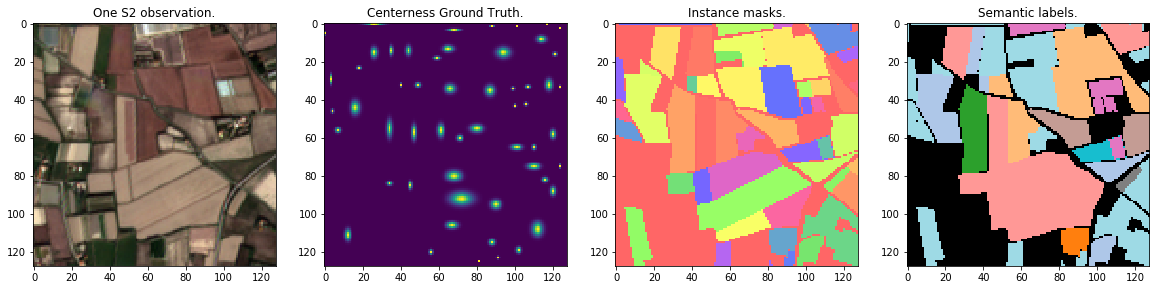

In [60]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,4, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(target_heatmap[bid].squeeze())
axes[2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[3].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Centerness Ground Truth.')
axes[2].set_title('Instance masks.')
axes[3].set_title('Semantic labels.')

plt.show()

# PASTIS-R

In [61]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTISR, norm=True, target='instance', sats=['S2','S1A','S1D'])
dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [74]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# When using PASTIS-R with the three modalities, x now contains
# one key for each modality:
print('S2 time series:' , x['S2'].shape)
print('S1A time series:' ,x['S1A'].shape)
print('S1D time series:' ,x['S1D'].shape)


(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)


S2 time series: torch.Size([2, 43, 10, 128, 128])
S1A time series: torch.Size([2, 65, 3, 128, 128])
S1D time series: torch.Size([2, 70, 3, 128, 128])


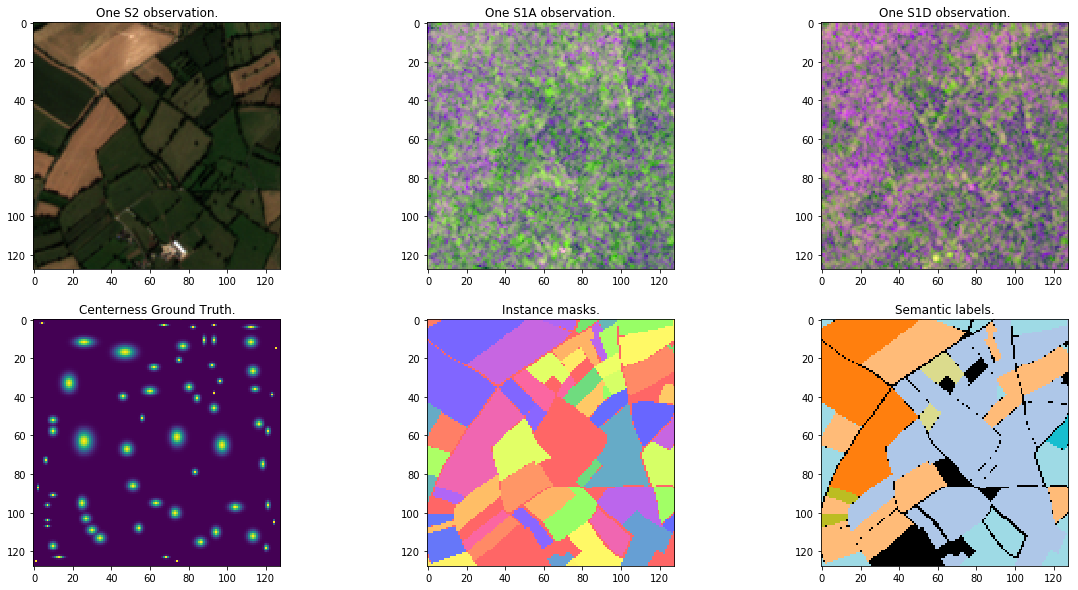

In [75]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(2,3, figsize=(20,10))

axes[0,0].imshow(get_rgb(x, batch_index=bid))
axes[0,1].imshow(get_radar(x, batch_index=bid, orbit='A'))
axes[0,2].imshow(get_radar(x, batch_index=bid, orbit='D'))

axes[1,0].imshow(target_heatmap[bid].squeeze())
axes[1,1].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[1,2].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0,0].set_title('One S2 observation.')
axes[0,1].set_title('One S1A observation.')
axes[0,2].set_title('One S1D observation.')

axes[1,0].set_title('Centerness Ground Truth.')
axes[1,1].set_title('Instance masks.')
axes[1,2].set_title('Semantic labels.')

plt.show()

# PASTIS-R Pixel-Set

In [78]:
from dataloader_pixelset import PASTIS_Dataset_PixelSet
from collate import pad_collate

dtp = PASTIS_Dataset_PixelSet(PATH_TO_PASTISR_pixel, n_pixel=32, sats=['S2','S1A','S1D'])
dlp = torch.utils.data.DataLoader(dtp, batch_size=64, collate_fn=pad_collate, shuffle=True)

Reading parcel metadata . . .
Done.
Getting geometric features . . .
Dataset ready.


In [91]:
# Loading a batch from the dataloader
batch = dlp.__iter__().__next__()

# In this format the batches are loaded in the form of a single dictionary:
# S2  : (X_s2, pixel_mask_s2) of shape B x T_s2 x C_s2 x n_pixel and B x n_pixel
# S1A  : (X_s1a, pixel_mask_s1a) of shape B x T_s1a x C_s1a x n_pixel and B x n_pixel
# S1D  : (X_s1d, pixel_mask_s1d) of shape B x T_s1d x C_s1d x n_pixel and B x n_pixel
# dates-S2  : dates of S2 observations (shape B x T_s2)
# dates-S1A  :  dates of S1A observations (shape B x T_s1a)
# dates-S1D  :  dates of S1D observations (shape B x T_s1d)
# label  : labels of the batch (shape Bx1) 
# geomfeat  : geometric features of the parcels (shape Bx4)